# Implementing a Deep Neural Network from Scratch - Part 1
> In this series we'll build a Neural Network from the ground up, covering basic concepts along the way. In Part 1 we will cover some fundamentals, create a simple baseline algorithm and build our first model.

- toc: true
- badges: false
- comments: true
- categories: [machine-learning]
- image: images/nn-from-scratch-part-1.png
- sticky_rank: 1
- keywords: machine learning, ml, deep neural network, neural network, convolutional neural network, beginner concepts, fastai, fast.ai, pytorch

## Introduction

One of the best ways to truly understand an algorithm, an API, or really any practical concept, is to build it yourself. In this blog post, we will implement a Deep Neural Network Multi-Label Text Classifier from scratch using Python, debunking the impression that modern Machine Learning is an obscure black box full of mind-bendingly complicated math. 

Our goal will be to create a Neural Network that can distinguish all 10 handwritten digits (using the industry standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset). This is also known as a Multi-Label Classifier (a single-label classifier only has two labels, such as cat or dog, hotdog or not hotdog, etc). I'll be basing this post on Lesson 4 of the excellent [fast.ai tutorial](https://course.fast.ai/) on Deep Learning, where Jeremy Howard shows how to distinguish whether a digit is a 3 or a 7 (a single label classifier). We'll need to change some things to make it work for all ten digits (0-9).

To truly test your understanding, I encourage you to try this yourself with a different type of dataset.

## Terminology

Most concepts that appear complicated are actually quite simple once you look at its building blocks. Complexity often arises from an aggregation of simplicity, and with Neural Networks this is exactly the case. The foundation of a Neural Network is collection of neurons. A neuron takes in a value, does a mathematical operation and outputs another value. That's it. The reason Neural Networks are powerful, is in the _how_: how the neurons work together, and how the output values in each neuron are calculated.

If you remember from high school math, one of the simplest equations is that of a linear function (i.e. the equation of a straight line): 

$y = \textbf{a}x + \textbf{b}$

$\textbf{a}$ and $\textbf{b}$ are constants (i.e. numbers like 2 or 3). For any value $x$ that we feed in, $\textbf{a}$ influences that slope (or gradient) of the line, $\textbf{b}$ determines the offset of the line along the $y$ axis.

![](images/2xp1.png)

[Here is an interactive example](https://www.mathsisfun.com/data/straight_line_graph.html) where you can see how $x$ is affected by changes in $\textbf{a}$ and $\textbf{b}$.


Guess what: each neuron in a Neural Network is a linear function almost identical to the above. The main differences lie in how we call each parameter and how the values of the function are affected once we start connecting neurons together. This is why we refer to the neurons as "**linear units**". From here on out, we'll call them linear units or LU(s).

The function for a linear unit is equivalent to the one we saw earlier:

$y = wx + b$

Almost identical right? The only difference is that $a$ turned into a $w$. This is because at the heart of a linear unit, the input is affected by a **weight** $w$ and a **bias** $b$. Here's another way to look at it, visually:


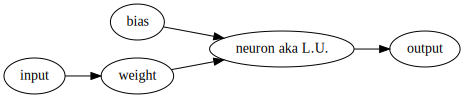

In [3]:
#hide_input
gv('''
bias->"neuron aka L.U."->output
input->weight->"neuron aka L.U."
''')

Why so much fuss about Neural Networks? Well, the power of neural networks is that theoretically they are able to approximate any function, at any level of accuracy. This is called the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem). If you're interested in diving deeper into how this works, I recommend reading [this post](http://neuralnetworksanddeeplearning.com/chap4.html) that visually (and interactively) shows how Neural Networks are able to approximate any function. 

We've made some bold claims: something that can replicate any known function with _any_ level of theoretical accuracy...and just thanks to a simple linear function? Well, yes! And no. As mentioned ealier, the real magic of a Neural Network lies not in how each neuron (linear unit) behaves independently, but how they behave as a whole. We'll see how this works as we build our Neural Network.

By the way, if you need a little more context on the topics covered above, I highly recommend the [Kaggle course](https://www.kaggle.com/ryanholbrook/a-single-neuron) on the subject.

## Getting Started

Now that we've understood what lies at the foundation of a Neural Network, we can start implementing it. Let's begin by importing and taking a look at the data we will be using. 

In [2]:
path = untar_data(URLs.MNIST)

Our data is made up of two directories: `training/` and `testing/`. In each folder, the PNGs of the digits (0 to 9) are grouped into folders themselves. The training dataset has a total of 60,000 reference images and the testing a total of 10,000 (so roughly a 15-16% validation split). 

```
mnist_png/ (70,000 files) 
├── training/ (60,000 files)
│   ├── 0/
│   │   ├── 44897.png
│   │   ├── 28230.png
│   │   └── ...
│   ├── 1/
│   │   ├── 44680.png
│   │   ├── 37659.png
│   │   └── ...
│   ├── ...
│   └── 9/
└── testing/ (10,000 files)
    └── ... (same structure as training/)
```

The reason we need the two folders is that we'll "learn" how to recognize the digits using the larger training set, and measure our performance accuracy against the testing dataset. If we were to test our performance on the dataset we learn from, we would always inevitably get 100% accuracy as the model learns to distinguish individual files. This sounds great, but the reality is it would perform terribly in a production environment when it encounters images of digits it has never seen before.


In [4]:
# Importing the paths of our training and testing images
training = { f'{num}' : (path/f'training/{num}').ls().sorted() for num in range(10) }
testing = { f'{num}' : (path/f'testing/{num}').ls().sorted() for num in range(10) }

In [6]:
# Let's take a look at a random 0
zero_path = training['0'][0]
zero = Image.open(zero_path)
zero

In order to work with our images, we need to convert this image into a numerical representation. Usually, a 2D image is represented by a matrix array (i.e. a Python list, a Javascript array, etc). There are a couple Python libraries that have extended the standard list object to be a bit more flexible (e.g. a numpy array). The object we'll be using is a PyTorch tensor. PyTorch is a popular Deep Learning Python Library. While _tensor_ may sound like a fancy name, it's nothing more than an array that has a couple extra features. From here on out, when we refer to a tensor, we mean an array. Let's convert our zero to a tensor and visualize it numerically:

In [ ]:
tensor(zero)

![](images/zero_tensor_1.png)

Without being Neo from the matrix, you can make out the zero drawn as if in ascii text. This is because each value of the array represents a pixel value, in the case of grey scale, from 0 to 255. Any place there is no color data, we have 0s.

Given that this is a 2D matrix, we can access specific parts of the tensor using notation such as `zero[5:10,5:10]` which will output the rows from index 5 (included) to 10 (excluded) and the same for the columns.

In [8]:
z_t = tensor(zero)
z_t[6:10,10:15] # This will output rows 7-10 (index 6-9) and columns 11-15 (index 10-14)

tensor([[  0,   0,   0,  54, 227],
        [  0,  10,  60, 224, 252],
        [  0, 163, 252, 252, 252],
        [ 51, 238, 253, 253, 190]], dtype=torch.uint8)

Let's visualize the tensor a little better:

In [ ]:
df = pd.DataFrame(z_t)
df.style.set_properties(**{'font-size':'5pt'}).background_gradient('Greys')

![](images/zero_tensor_2.png)

This is the anatomy of our digits: 28 rows long by 28 columns wide, making a total of 784 pixels each. Each pixel is represented by a value from 0-255.

Before we start, let's first ponder on how we could, without knowing _anything_ but the structure of the data, teach a computer how to differentiate between the digits. We'll do that in the next section, and use it as a baseline to measure our Neural Network against.

## Establishing a Baseline

We'll begin our implementation by implementing something that _isn't_ a neural network. It sounds counter-intuitive, but in order to get a good understanding of the performance of our model, we should always have a simple baseline with which to compare it against. Usually a good baseline is something simple, easy to create, and easy to understand. Seeing as how we're building everything from scratch, we may as well build our baseline from scratch as well. 

In our case, there are several ways to approach this problem without knowing a single thing about machine learning. One approach could be just comparing the pixel similarity of the digits. This can be done by counting the average number of non-0 pixels for each image, or measuring the average pixel value of each image, or the average sum of pixel values, etc). Let's pick comparing average pixel values as the "algorithm" for our baseline algorithm. 

### Average Pixel Value

To calculate average pixel value, we will take the average value of each pixel coordinate across every respective digit's training image's tensor. For example, we take all the '5' image tensors, we look at the first coordinate (1,1) in each tensor and we take the average value. We repeat the process for each coordinate until we create a map of average values across the 28x28 grid of pixels. An easy way to do this is to create a tensor that "houses" all of the individual image tensors. This will take our tensor from 2 dimensions, to 3 (also called a rank-3 tensor). This allows us to work with all of the tensors as a single stack, and conduct mathematical operations such as `tensor.mean()` without looping. We'll see later why that's not just convenient, but very important for performance.

Going into the third dimenion sounds complicated, but all we're really doing is nesting each of the digit's various PNGs' tensors into a larger tensor. We do this with PyTorch's `stack` method which does just that. While we're at it, we'll also normalize our pixel values to be from 0 to 1 by dividing by 255 after converting them to float.


In [5]:
# Generate training tensors for each digit in the training list:
# For each digit from 0 to 9, we create a stacked tensor 
# containing the tensors for each PNG image, after converting
# each pixel value to a float and dividing it by 255.

training_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in training[f'{num}']
          ]) for num in range(10)
      ]

# Preview the shape of the stacked tensors of the "zero" digit PNGs
training_tensors[0].shape

torch.Size([5923, 28, 28])

We now have a list of stacked tensors (i.e. a list of stacked tensors of each digit). Each stacked tensor has $n$ tensors for each PNG image (rows), and each row contains a 28x28 tensor representing that PNG's pixel values normalized from 0 to 1.

We can check this by inspecting the first item in our list of `training_tensors`: the stacked tensor of "zero" PNGs has _shape_ `torch.Size([5923, 28, 28])`: because it has 5923 rows (equal to the number of training images), each containing a 28x28 tensor (equal to the pixels in each image). If you're having trouble picturing a 3D tensor in your head, think of it like an array of array of arrays (or a list of list of lists in Python). 

## Calculating Average Pixel values

The convenient part of having used tensors, is that now we can quickly calculate the mean across a desired dimension (in our case: flatten each stack into a single 28x28 tensor containing the average values of each pixel in the stack). 
>Tip: Think of it like printing out all the PNG images for a specific digit and stacking each page one on top of the other. That's exactly what we did with out stacked tensor. And now, with special X-Ray vision, we are going to reduce the stack to a single page by taking the average value for each printed pixel across the stack of pages. 


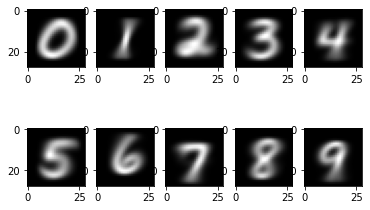

In [11]:
# Flattening the stacks to calculate the means
training_means = [t.mean(0) for t in training_tensors]

# Let's display the "mean" tensor of the digits
f, axarr = plt.subplots(2,5)
digit = 0
for i in range(2):
  for j in range(5):
    axarr[i,j].imshow(training_means[digit], cmap="gray")
    digit += 1

Pretty cool right? That is the "average" pixel value for each digit, representing in a way the _ideal_ digit according to our baseline algorithm that will compare the validation digits against this mean. The value we will be measuring is called _distance_. Our validation digits will of course be very different from these reference means, but hopefully the pixel values will be nearest in _distance_ to the mean pixel value of the correct digit! Let's see if that's the case...

### Measuring Distance

In order to measure the distance between our reference means and the validation digits, we need to subtract them. However we can't simply subtract them, as that would create negative numbers and our pixel values go from 0 to 1. 

To avoid dealing with negative numbers, there are two common measures of distance that get rid of negative numbers altogether:
-  **mean absolute difference** (aka L1 Norm)
-  **root mean squared error** (aka RMSE or L2 Norm). 

If these sound confusing you'll see how simple they are in just a second.

**Mean Absolute Difference**: $mean( abs( a - b ) )$. For each prediction, we subtract our prediction from the actual value, turn that difference into a positive number (i.e. remove the negative sign if there is one) and then average all the these differences together together. 

**Root Mean Squared Error / RMSE**: $\sqrt[]{mean((a-b)^2)}$. For each prediction, we subtract our prediction from the actual value, square the result (so as to turn it into a positive number) and then take the square root, so as to "cancel out" the squaring. 

In code, they are even easier:

In [12]:
def mean_absolute_difference(a, b):
    return (a - b).abs().mean()

def rmse(a, b):
    return ((a - b)**2).mean().sqrt()

Now that we've defined them, let's pick a random image from the validation set (e.g. the first image in the '5' in the testing list) and calculate its distance from the training set's reference mean. 

In [13]:
val_5 = tensor(Image.open(testing['5'][0])).float()/255
# val_5.shape => torch.Size([28, 28])

# Let's compare it to the reference mean of 5
mean_absolute_difference(training_means[5], val_5), rmse(training_means[5], val_5)

(tensor(0.1683), tensor(0.2988))

In [14]:
# Now let's compare it to all the other means
mad_all = [mean_absolute_difference(training_means[num], val_5) for num in range(10)]
rmse_all = [rmse(training_means[num], val_5) for num in range(10)]

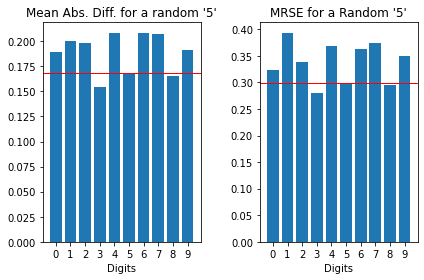

In [15]:
#hide_input
# Plot results for a visual inspection
plt.subplot(1, 2, 1)
plt.title("Mean Abs. Diff. for a random '5'")
plt.axhline(mad_all[5], color='red', linewidth=1)
plt.xticks(range(0, 10))
plt.xlabel('Digits')
plt.bar(range(len(mad_all)), mad_all, align='center')    
plt.plot()

plt.subplot(1, 2, 2)
plt.title("MRSE for a Random '5'")
plt.axhline(rmse_all[5], color='red', linewidth=1)
plt.xticks(range(0, 10))
plt.xlabel('Digits')
plt.bar(range(len(rmse_all)), rmse_all, align='center')    
plt.plot()

plt.tight_layout()
plt.show()

Remember, we want the lowest distance (either measured via Mean Absolute Difference, or RMSE) to be the one between our PNG and the digit's "reference mean" (i.e. the mean we calculated representing the average of all the training digits of that type). 

We can already see that for this particular 5 in our dataset, our distance measures are actually lower for other numbers (e.g. 3, 8). This isn't desired, but also isn't too surprising, as the handwritten digits are visually very similar. Let's see if this holds up on average for all the 5's, and whether our algorithm will perform better for other digits.

We'll continue by loading all of our validation images:

In [6]:
validation_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in testing[f'{num}']
          ]) for num in range(10)
      ]

# Preview the shape of the stacked validation tensors of the "zero" digit
validation_tensors[0].shape

torch.Size([980, 28, 28])

We need to write a function that takes each tensor stack in our `validation_tensors` list (one for each digit), and for each tensor in the stack measures the distance from the corresponding mean. 

Thanks to PyTorch's efficient use of broadcasting, we can feed in a stack as $a$ and a single tensor as $b$ (or viceversa) and PyTorch will automatically stack the single tensor multiple times to match the length of the stack. This allows the computation to be done using low-level C on the GPU (i.e. in parallel) and is several orders of magnitude faster than a regular Python `for` loop. Thankfully, our distance function doesn't need to change a whole lot, the only change being to add along which axes to calculate the mean in our tensor stack (see commented code below). We'll need another couple of functions to help us deal with multiple digits and multiple tensor stacks and aggregate all the scores.

You can read the source code below, but here's a quick explanation: for each stack of tensors (e.g. tensors of all of the '3' images) in our validation set, we calculate the distance from each digit's reference mean and check that the lowest distance is that of the correct digit's reference mean.

In [17]:
def distance(a, b):
  # Let's go with mean absolute error for now
  return (a - b).abs().mean((-1,-2)) # the last two axes (e.g. 28x28)

def is_correct(tensors, means, correct_index):
  # make a list of the wrong digits' means indices
  wrong_means = [i for i in range(10)]
  wrong_means.pop(correct_index)

  # calculate the distance from the correct reference mean
  correct_distance = distance(tensors, means[correct_index])

  # calculate and compare the distance to each wrong digit's reference mean
  # and then checking that the distance is the lowest across all digits.
  # each 'wdX' contains a tensor of Booleans -- eg tensor([True, False, ... ])
  wd1 = correct_distance < distance(tensors, means[wrong_means[0]])
  wd2 = correct_distance < distance(tensors, means[wrong_means[1]])
  wd3 = correct_distance < distance(tensors, means[wrong_means[2]])
  wd4 = correct_distance < distance(tensors, means[wrong_means[3]])
  wd5 = correct_distance < distance(tensors, means[wrong_means[4]])
  wd6 = correct_distance < distance(tensors, means[wrong_means[5]])
  wd7 = correct_distance < distance(tensors, means[wrong_means[6]])
  wd8 = correct_distance < distance(tensors, means[wrong_means[7]])
  wd9 = correct_distance < distance(tensors, means[wrong_means[8]])
  
  # now we 'and' all the Boolean tensors together
  wdf = torch.bitwise_and(wd1, 
                    torch.bitwise_and(wd2, 
                    torch.bitwise_and(wd3, 
                    torch.bitwise_and(wd4, 
                    torch.bitwise_and(wd5, 
                    torch.bitwise_and(wd6, 
                    torch.bitwise_and(wd7,
                    torch.bitwise_and(wd8, wd9))))))))
  
  return  wdf.float().mean()

def accuracy(stacks, means):
  accuracy_map = [is_correct(stacks[i], means, i) for i in range(10)]
  accuracy_tot = (sum(accuracy_map) / len(accuracy_map)).item()
  return accuracy_tot, accuracy_map         

Tot. Accuracy: 66.1%
Digit 0 : 81.5%
Digit 1 : 99.8%
Digit 2 : 42.3%
Digit 3 : 60.9%
Digit 4 : 66.8%
Digit 5 : 32.6%
Digit 6 : 78.7%
Digit 7 : 76.5%
Digit 8 : 44.3%
Digit 9 : 77.6%


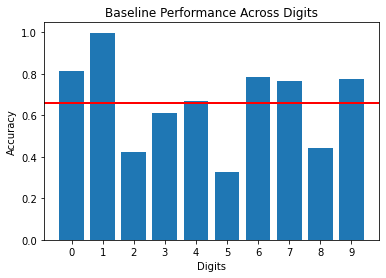

In [18]:
# Output our results!
tot, map = accuracy(validation_tensors, training_means)
print("Tot. Accuracy: {:.1%}".format(tot))
print("\n".join(["Digit {} : {:.1%}".format(i, map[i]) for i in range(10)]))

# Plot results for a visual inspection
plt.title("Baseline Performance Across Digits")
plt.axhline(tot, color='red', linewidth=2)
plt.xticks(range(0, 10))
plt.xlabel('Digits')
plt.ylabel('Accuracy')
plt.bar(range(len(map)), map, align='center')    
plt.plot(tot)
plt.show()

It seems our simple mathematical comparison of average pixel values already achieves 66.1% overall accuracy across the validation set! This is impressive considering some digits have similar strokes (e.g. 3, 5 and 8). You can see from the bar chart above, some digits perform better than others, with the '1' digit recognition achieving near perfect accuracy (99.8%) in stark contrast to the '5' digit (32.6%). 

So we've covered terminology, we've established a simple baseline based on pixel arithmetic. Let's start building this darn deep neural network!

## Thinking Like a Neural Network

While "Deep Learning" sounds sophisticated, the underlying learning process under the hood doesn't sound quite as futuristic: "try, rinse, repeat". However, the real magic lies in the details, more specifically in how it "rinses" each cycle. After every cycle, it will adjust its own parameters to be "better". We'll see how it does this in just a second. Now let's reflect on our simple baseline method.

Our baseline approach uses a very deterministic, binary algorithm for deciding whether a digit is correct or not: it will compare pixel distance with each reference mean and pick the mean where the distance is lowest. Considering that the input pixels and reference pixels never change, for each image our model will either be correct 100% of the time, or it will fail 100% of the time. There is no feedback loop, no way for the model to adjust along the way and no "randomness".

Remember that our Linear Units have _parameters_. More specifically, each Linear Unit has a _weight_ and a _bias_: 

$y = \textbf{w}x +\textbf{b}$

The beauty of parameters is that they can be tweaked, and the output $y$ will be different, much like we saw in our linear equation at the beginning of the post. 

With this simple equation as the engine for its neurons, a Neural Network is able to approximate anything. The approximation process is possible due to the iterative nature of trying a set of parameters, adjusting them and trying again. But how, you may be wondering, does a model choose the new set of parameters? Is it a random choice? Is it decided by a function? The answer is an inclusive "yes": it starts off with random values and gradually adjusts them according to a function: **the loss function**. The loss function measures how accurate the prediction is. The **optimizer function** then updates the parameters so as to minimize the loss function. It does this by looking at the rate of change (the gradient, aka slope) of each parameter as it was fed into the loss function and updates them (also called "to step") in the direction that will minimize the loss function. And this process has a fancy name, called **Stochastic Gradient Descent**. 
- _Descent_ because we want to get to make our way to the lower end of the loss function, 
- _Gradient_ because we use the gradient of each parameter to find in what direction to update them to make that descent, and 
- _Stochastic_ because it involves a litte bit of randomness, meaning it's not deterministic.

Let's summarize all these steps again:
1. We initialize the parameters (weights and biases for each input) to random values
2. Make a prediction using those parameters
3. Measure the accuracy of the prediction using a **loss function**
4. We calculate how to update our parameters so as to minimize the loss function (remember: lower is better) using the **gradients** of the parameters' change as a result of the loss function. This is done via the **optimizer** function.
5. We update our parameters and predict again, repeating the cycle until we are satisfied or the model stops improving significantly.

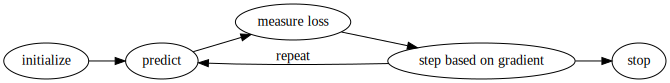

In [19]:
#hide_input
gv('''
initialize->predict->"measure loss"->"step based on gradient"->"stop"
"step based on gradient"->predict[label=repeat]
''')

Let's begin by implementing _something_ that follows these rules. The reason I call it _something_ is that you'll see later why it's not exactly a Deep Neural Network. But it will help us learn along the way and take it step by step.





## Primordial Neural Network

Our first Neural Network will start with a parameter for each pixel value of the input image ($28 \times 28 = 784$), and will be fed directly into our loss function to measure our prediction accuracy. That means that our output needs to be a list of 10 probabilities--each probability corresponding to the likelihood that our reference image corresponds to a specific digit. These probabilities will need to sum to 1, as the classification is mutually exclusive (i.e. a '3' can only be a '3'). Other multi-label classification approaches are inclusive, meaning each input could have multiple labels (e.g. deciding if an image contains a person and/or a car and/or any other object). 

How do we condense all of our parameters into a list of probabilities? Say hello to my little friend: **Softmax**.

### The Softmax Function

The beautify of the Softmax function is that it normalizes a group of values from 0 to 1 in a way so that each value is interrelated with the others: together they sum to 1. This is perfect for generating a list of interrelated probabilities. If we were creating non-mutually exclusive classification, we would use Softmax's cousin Sigmoid, that normalizes each value from 0 to 1 _independently_. I'll leave diving deeper on the topic of Softmax vs Sigmoid as homework--you can start with this brilliant [blog post](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/).


Let's admire Softmax in all of its glory:

$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_j{e^{x_j}}}$

Don't worry, it's a lot simpler than it looks, and is even simpler once we code it.Here's a quick explanation of how our Softmax works in three steps:
1. Given a list of values, we calculate the exponential for each value, that is: $e^{n}$. Where $n$ is our value and $e$ is Euler's number, a [special number in Mathematics](https://en.wikipedia.org/wiki/E_(mathematical_constant)), and at the heart of the exponential function.
2. We sum the exponential values (the Sigma symbol $\sum$ means _sum_).
3. Take each value in Step 1. and divide it by the sum obtained in Step 2. 

As Jeremy Howard says: a mathematical concept often sounds complicated until you code it. So let's code it. Below is my quick softmax implementation:


In [20]:
# Quick softmax implementation, expecting a list of values (rank-1 tensor)
def softmax(v):
  """
  Given an input vector v, returns an output vector containing
  the softmax values for each element in the vector
  """
  exp_v = torch.exp(v.float())
  exp_sum = exp_v.sum()
  return exp_v / exp_sum

In [21]:
# An softmax example with a list of values [1,2,3]
softmax(tensor([1,2,3]))

tensor([0.0900, 0.2447, 0.6652])

### Datasets 

Now that we have Softmax in our toolbelt, we can move on with the implementation. Let's start by preparing our data. We'll take our tensor stacks. Let's reduce the dimensions of our data by transforming each image tensor from a matrix of 28x28 to a vector (a list) of size 28*28 (meaning each pixel is in a series, not in a 2D coordinate space)

In [11]:
# Create a single list containing all the image tensors, as vectors
train_x = torch.cat(training_tensors).view(-1, 28*28)
valid_x = torch.cat(validation_tensors).view(-1, 28*28)

In [23]:
train_x.shape, valid_x.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

As you can see from the output of `train_x.shape`, we went from a rank-3 tensor (60000, 28, 28) to a rank-2 tensor (60000, 784). We now want as many outputs from our model as number of labels (in our case digits). So we need to flag for each training image which is the correct digit. To do this we'll populate a tensor of length 10 as our corresponding target labels (also referred to as $y$ variables. In that case our inputs are usually referred to as $X$, representing our features) and add a "1" to flag the corresponding index in the tensor corresponding to our digit. You can see what it looks like for each digit below. 

Each row represents the correct label representation for each digit. For example, the first row is the output labels valid for _all_ the 'zero' tensors (index 0 is set to 1, and the rest are 0), the second being the output labels for _all_ the 'one' tensors (index 1 is set to 1 and the rest are 0), etc. In a way, the 1's location inside the indicates 100% probability that that index represents the correct digit. Ideally, we want our model to output the exact same output. 

In [2]:
# Every digit's tensor stack will have a label
# with the corresponding index flagged as '1'.

[[0]*i + [1] + [0]*(9-i) for i in range(10)]

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

Let's associate a target label for each tensor in our stack, with the '1' corresponding to the digit it represents. 

In [12]:
# Label our training and validation sets with the index
train_y = torch.from_numpy(np.concatenate([[[0]*i + [1] + [0]*(9-i)]*len(training[f'{i}']) for i in range(10)]))
valid_y = torch.from_numpy(np.concatenate([[[0]*i + [1] + [0]*(9-i)]*len(testing[f'{i}']) for i in range(10)]))

In [26]:
train_y.shape, valid_y.shape, train_y[0]

(torch.Size([60000, 10]),
 torch.Size([10000, 10]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Let's now merge them into a _dataset_. A dataset contains both $X$ and $y$ variables so that the model knows what $y$ to compare the prediction of $X$ against. We'll populate a training dataset with which to train the parameters, and a validation dataset that the parameters will never "learn" from, with which to benchmark our training against. A model may be very good at learning the peculiarities of its training data but may end up performing very poorly on its validation data as the features learned are not generalizable. This phenomenon is referred to as **over-fitting**.


In [13]:
# Let's turn our training and validation X (features) and y (targets)
# into datasets by zipping them so as to create a list of tuples (image tensor vector, label )
dset = list(zip(train_x, train_y))
dset_valid = list(zip(valid_x, valid_y))

x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

### Parameters

What we'll do now is start defining functions that we'll end up merging into a single model class. The first function we'll need is a function that simply initiates random numbers, and these random numbers will be our weights and biases for each pixel.

We'll use the `.requires_grad_()` in-place operation to ask PyTorch to track the gradients, as we'll need them later to backtrack and update our parameters according to the loss function.

In [28]:
def init_params(sizeD1, sizeD2=0):
  if sizeD2 == 0:
    return (torch.randn(sizeD1)).requires_grad_()
  else:
    return (torch.randn(sizeD1, sizeD2)).requires_grad_()

In [29]:
weights = init_params(28*28, 10) # the 'w' of the linear equation
bias = init_params(10) # the 'b' of the linear equation

In [44]:
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

### Linear Equation

Next we need a function that performs the famous Linear Unit (neuron) operation that we've been talking about since the beginning of the post. It's as simple as:

In [45]:
def linear_eq(x):
  return x@weights + bias

Next we'll feed our training data `train_x` into our linear equation, which will associate the parameters we created earlier via matrix multiplication. That's what the `@` stands for in our function above. This gives us a first set of predictions (`preds`) that should perform quite poorly, more or less as well as picking the digits at random. 

In [32]:
# Calculate predictions on all the tensors
preds = linear_eq(train_x)
preds

tensor([[-11.9867,  -4.2706,   4.6806,  ...,  -1.3517,  -0.0395,  13.5840],
        [ -6.6797,  -4.4483,   1.4827,  ...,  -8.9409,   2.2570,  10.0881],
        [-22.7994,   2.2295,  11.1160,  ...,  -1.8488,  25.5523,  22.3240],
        ...,
        [-16.7386,   4.0141,   3.9273,  ...,   1.5960,   9.7961,  12.3801],
        [-14.1562,  -3.5679,   1.7541,  ...,   1.6506,  16.5308,  10.3213],
        [-11.3688,   4.5965,   5.7170,  ...,  10.0353,   4.4967,   9.5438]], grad_fn=<AddBackward0>)

In [33]:
# Check accuracy
_, max_indices = preds.max(-1) # get the index of max value along 2nd dimension
_, tag_indices = train_y.max(-1) # get index of flag in our label tensors

corrects = max_indices == tag_indices # check whether they match
corrects.float().mean() # calculate mean

tensor(0.1204)

We see here that randomly initialized parameters will perform more or less like...well...a random choice. In our test above we got a 12% performance rate versus a random chance of 10% (choosing a random number from 1 to 10). This is expected and a good sense check that our model parameters are initialized randomly. Now comes the fun part. Let's create a loss function against which it can measure itself. After that, we'll see how can create an optimizer function that will decide how to update the parameters to minimize the loss function, so as to continuously improve cycle after cycle.

We'll first softmax our parameters so that they are between 0 and 1, and we'll check whether the outputs match the targets. 


In [49]:
# We'll use PyTorch's built in softmax function 
# so we can work in multiple dimensions easily.
# It works exactly like our own softmax()
def loss_function(predictions, targets):
  sm = nn.Softmax(dim=-1) # instantiate PyTorch's softmax in the 2nd dimension
  predictions = sm(predictions) # calculate the softmax across the 2nd dimension
  return torch.where(targets==1, 1-predictions, predictions).mean(-1)


In [50]:
loss_function(preds, train_y)

torch.Size([60000, 10])


tensor([0.2000, 0.2000, 0.2000,  ..., 0.0141, 0.1996, 0.1299], grad_fn=<MeanBackward1>)

### The Optimizer

Once our model instantiates random parameter values, makes a prediction and measures the first prediction against the loss function, we now have "report card" for how it performed. Staying with that analogy, now is the time to read our report card (our "grades" are the distances from the target value) and fix our parameters so we get a better grade the next time around, using the teacher's feedback (our gradients).



We first need to get our gradients, and then update our parameters using a simple formula in Stochastic Gradient Descent. This is what the formula looks like for each parameter $w$:

$ w := w - \eta \nabla Q({w}) $

As usual, this looks super complicated until you see it in code:

In [ ]:
# Compute the loss
loss = loss_function(preds, yb)

# Get the gradients
loss.mean().backward()

# Optimize our parameters
for p in [weights, bias]:
    p.data -= p.grad*lr # this line is the formula above
    p.grad.zero_()

All we're doing is just subtracting the gradient! To get the gradient, `p.grad`, we need to use PyTorch's `.backward()` functionality on the output of our `loss_function`, $Q$, so it can calculate the gradients for all the parameters in our weight and bias tensors as a result of the loss function. This is done automatically thanks to the fact that we added `.requires_grad_()` earlier to our parameters.

If you have a keen eye, you'll see in the code that we muliply the `p.grad` by a value called `lr`. This is the **learning rate**, $\eta$ in the formula. This is just a weighing factor we use to reduce the amount of movement along the loss function from one update to the next. Typical values range from 0.001 to 0.1. Why is it important to not go too much in one direction? If you imagine a loss function like a parabola, our optimal point is at the bottom of the parabola. If we overshoot, we could be bouncing around from one side of the parabola to the other. A smaller step-based approach helps prevent that.

### Batches

Before we combine everything together into a model, let's introduce the concept of **batches**. Rather than measure predictions across all the dataset before estimating our performance, research has found that doing it with batches of training data is significantly faster and yields good results. This is also referred to as _mini-batches_. It's a compromise between having to run your function against _all_ the values in the training dataset every time (therefore requiring a lot of resources when you have millions of items to process), or doing it for each single item in the dataset, which would be fast, but would not be representative of the group. Either extremes are bad for different reasons, so a good compromise is selecting a random batch of samples every time, and running the prediction-loss-step cycle on that batch thereby updating the parameters. A good batch size is small enough to be performant and large enough to be somewhat representative of the overall dataset. When we complete a round of batches (i.e. all of our samples are used in training exactly once), we have completed an **epoch**. 

For batching, we'll use fast.ai's DataLoader. While it offers a lot of additional functionality, all we'll use it for is as an iterator that will split up our inputs into batches to feed into the model until all the samples are fed through. 



In [14]:
dl = DataLoader(dset, batch_size=128, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=128, shuffle=True)

### Our MNIST Model

Now that our dataset is conveniently split up into batches, we can combine all the different functionality we saw up until now and create an MNIST Model class to train. Below is a (naive and specific) implementation of a Model specifically trained to deal with the characteristics of our MNIST task.

Our class has the following characteristics (feel free to skip ahead and just read the source code directly)

#### Inputs

This is what the model needs to instantiate:
- `train_dl`: our training DataLoader
- `valid_dl`: our validation DataLoader
- `epochs`: the number of epochs (complete rounds of the training data to perform)
- `lr`: our learning rate
- `verbose`: which just flags whether we want to print out feedback.

#### Functions

These are the functions our model uses to perform the operations. They are prefixed with an `_` to differentiate them from our methods.
- `_print()`: is just a simple print function that only prints if flag `verbose` is true.
- `_init_params()`: our initializes parameters.
- `_linear_eq()`: our linear equation above.
- `_loss_function()`: our loss function above.
- `_calc_grad()`: takes the input training data, runs it through `_linear_eq` to get predictions and calculates the loss via the `_loss_function`. Then calls `.backwards()` on the loss results to get the gradients.
- `_batch_accuracy()`: softmaxes a prediction and compares it against the corresponding label. That is, the index with the max value in the vector (highest probability) should be the same as the index with the '1' flag in our label vector. True if it's the case, False otherwise. Then returns the mean result, representing our batch accuracy. This is used in our `_validate_epoch` function and only used with validation data.
- `_validate_epoch()`: once a training epoch is complete, we run our model through each batch of our validation data and cumulatively aggregate accuracies of each batch obtained via `_batch_accuracy` into an overall epoch score.

#### Methods

Our model has two main methods: `train` and `predict`. 
- `train`: for each epoch, for each batch performs the training (via `_calc_grad`), the optimizing and validates each epoch (via `_validate_epoch`). 
- `predict`: similar to _batch_accuracy but only works on a single input image. It expects an image tensor as input and runs the tensor through its current parameters, outputting its predicted digit as well as the probabilities for other digits.

In [7]:
#collapse_show
class MNISTLinearRegression:
  def __init__(self, train_dl, valid_dl, epochs, lr, verbose):
    self.lr = lr
    self.train_dl = train_dl
    self.valid_dl = valid_dl
    self.epochs = epochs
    self.weights, self.bias = self._init_params()
    self.softmax = nn.Softmax(dim=-1)
    self.accuracy_scores = []
    self.verbose = verbose

  def train(self):
    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        self._calc_grad(xb, yb)
        for p in [self.weights, self.bias]:
            p.data -= p.grad*self.lr
            p.grad.zero_()

      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self.softmax(self._linear_eq(image_tensor))
    _, prediction = probabilities.max(-1)
    #self._print("Predicted digit: {} (with {:.2%} confidence)".format(1,0.9))
    # Return digit and vector of probabilities
    return prediction, probabilities

  def _calc_grad(self, xb, yb):
    preds = self._linear_eq(xb)
    loss = self._loss_function(preds, yb)
    loss.mean().backward()

  def _batch_accuracy(self, xb, yb):
    predictions = self.softmax(xb) # calculate the softmax across the 2nd dimension
    _, max_indices = xb.max(-1) # get the index of max value along 2nd dimension
    _, tag_indices = yb.max(-1) # get index of flag in our label tensors
    corrects = max_indices == tag_indices # check whether they match
    return corrects.float().mean() # calculate mean

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._linear_eq(xb), yb) for xb,yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    self._print(f'Epoch #{i}', score)

  def _linear_eq(self, x):
    return x@self.weights + self.bias

  def _loss_function(self, predictions, targets):
    predictions = self.softmax(predictions) # calculate the softmax across the 2nd dimension
    return torch.where(targets==1, 1-predictions, predictions).mean(-1)

  def _print(self, *args):
    if self.verbose:
      print(*args)

  # Linear regression using SGD
  def _init_params(*args):
    return (torch.randn(28*28, 10)).requires_grad_(), (torch.randn(10)).requires_grad_()




Now that we've created it, let's try it in action!

In [19]:
model = MNISTLinearRegression(dl, valid_dl, 50, 1, True)

In [20]:
model.train()

Epoch #0 0.225
Epoch #1 0.2896
Epoch #2 0.335
Epoch #3 0.3665
Epoch #4 0.4239
Epoch #5 0.4645
Epoch #6 0.486
Epoch #7 0.5055
Epoch #8 0.5214
Epoch #9 0.5243
Epoch #10 0.5343
Epoch #11 0.5356
Epoch #12 0.5389
Epoch #13 0.5466
Epoch #14 0.5463
Epoch #15 0.5468
Epoch #16 0.5506
Epoch #17 0.5522
Epoch #18 0.553
Epoch #19 0.5556
Epoch #20 0.5578
Epoch #21 0.5579
Epoch #22 0.5573
Epoch #23 0.5617
Epoch #24 0.5599
Epoch #25 0.5615
Epoch #26 0.5599
Epoch #27 0.5615
Epoch #28 0.5604
Epoch #29 0.5602
Epoch #30 0.5666
Epoch #31 0.5702
Epoch #32 0.5837
Epoch #33 0.6356
Epoch #34 0.6464
Epoch #35 0.6619
Epoch #36 0.677
Epoch #37 0.6907
Epoch #38 0.6961
Epoch #39 0.7083
Epoch #40 0.7107
Epoch #41 0.7188
Epoch #42 0.7252
Epoch #43 0.7276
Epoch #44 0.7353
Epoch #45 0.7479
Epoch #46 0.7646
Epoch #47 0.7808
Epoch #48 0.7929
Epoch #49 0.8005


Not bad! After 50 epochs we reached 80% accuracy, way ahead of our baseline! I tried running this multiple times and the results vary, depending on the initial parameters and the learning rate.

Remember the example '5' we used earlier in the post to try out our baseline average pixel value approach? If you remember, it didn't even work properly as the distance to the reference means '3' and '8' was closer! Let's take that same image and see what our model predicts. 

In [38]:
val_5 = (tensor(Image.open(testing['5'][0])).float()/255).view(-1, 28*28)
a = model.predict(val_5)
a

(tensor([5]),
 tensor([[1.6423e-13, 7.6946e-22, 1.9228e-15, 2.0405e-04, 1.1598e-18, 9.9980e-01, 6.9507e-23, 2.2210e-20, 5.8148e-25, 1.8752e-18]], grad_fn=<SoftmaxBackward>))

Yay. It works! It correctly predicted the '5' digit, with probability 99.98%. 

## Activating our network!

You may have noticed that we called our model a "MNISTLinearRegressor". I have to break it to you, what we've done up to now is create a linear regressor with a self-correcting capability through Stochastic Gradient Descent..._not_ a neural network. That being said, we've gotten some pretty impressive results with just this linear classifier. However, a neural network is non-linear. How do we break the linearity? That is what we'll tack in **Part 2** (to be published soon)!